# Figures for QPGA paper


In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import qutip
import h5py

from qpga import *
from qpga.model import QPGA
from qpga.circuits import QFT, QFT_layer_count, cluster_state_generator
from qpga.training import *
from qpga.fidelity_search import *
from qpga.linalg import *
from qpga.plotting import *
from qpga.state_preparation import *
from qpga.callbacks import *
from qpga.utils import *

import tensorflow as tf
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
K.set_floatx('float64')

%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=3, linewidth=300)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Fidelity search plot

In [2]:
num_qubits = [3,4,5,6,7,8]
num_layers_explicit = [QFT_layer_count(n, nearest_neighbor_only=True, include_reshuffling=True) for n in num_qubits]
num_layers_SGD = [7, 11] + [25, 40, 55, 70] # last bit are made up, will fill in when computations finish

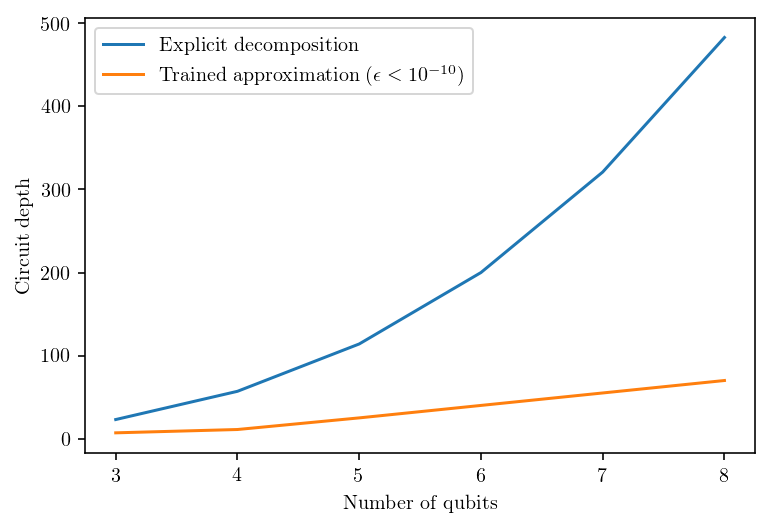

In [3]:
plt.figure(figsize=(6,4))
plt.plot(num_qubits, num_layers_explicit, label="Explicit decomposition")
plt.plot(num_qubits, num_layers_SGD, label="Trained approximation ($\epsilon < 10^{-10}$)")
plt.xlabel("Number of qubits")
plt.ylabel("Circuit depth")
plt.legend()
# plt.savefig("circuit_depth.png")
plt.show()

## NOON state preparation training plot

In [10]:
N = 4
num_samples = 1

in_data = np_to_k_complex(np.array([zero_state(N)] * num_samples))
out_data = np_to_k_complex(np.array([noon_state(N)] * num_samples))

model = QPGA(N, 20).as_sequential()
model.compile(optimizer=Adam(lr=0.002), 
              loss=antifidelity, 
              metrics=[antifidelity])

callback = StatePreparationHistoryCallback(num_qubits=N, input_state = in_data[0:1], target_state = out_data[0:1])
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor = 'loss', 
                                                       factor = 0.25,
                                                       patience = 2,
                                                       verbose=1,
                                                       min_lr=1e-6)

history = model.fit(in_data, out_data, epochs=201, 
                    callbacks=[callback, reduce_lr_callback], verbose = 2)

Epoch 1/201
1/1 - 15s - loss: 0.9720 - antifidelity: 0.9720
Epoch 2/201
1/1 - 0s - loss: 0.9573 - antifidelity: 0.9573
Epoch 3/201
1/1 - 0s - loss: 0.9396 - antifidelity: 0.9396
Epoch 4/201
1/1 - 0s - loss: 0.9190 - antifidelity: 0.9190
Epoch 5/201
1/1 - 0s - loss: 0.8957 - antifidelity: 0.8957
Epoch 6/201
1/1 - 0s - loss: 0.8700 - antifidelity: 0.8700
Epoch 7/201
1/1 - 0s - loss: 0.8423 - antifidelity: 0.8423
Epoch 8/201
1/1 - 0s - loss: 0.8128 - antifidelity: 0.8128
Epoch 9/201
1/1 - 0s - loss: 0.7819 - antifidelity: 0.7819
Epoch 10/201
1/1 - 0s - loss: 0.7501 - antifidelity: 0.7501
Epoch 11/201
1/1 - 0s - loss: 0.7175 - antifidelity: 0.7175
Epoch 12/201
1/1 - 0s - loss: 0.6846 - antifidelity: 0.6846
Epoch 13/201
1/1 - 0s - loss: 0.6517 - antifidelity: 0.6517
Epoch 14/201
1/1 - 0s - loss: 0.6192 - antifidelity: 0.6192
Epoch 15/201
1/1 - 0s - loss: 0.5874 - antifidelity: 0.5874
Epoch 16/201
1/1 - 0s - loss: 0.5568 - antifidelity: 0.5568
Epoch 17/201
1/1 - 0s - loss: 0.5276 - antifidel

In [24]:
def plot_state_prep_training(filepath, max_epoch=None):
    
    f = h5py.File(filepath, 'r')
    
    input_state = np.array(f['input_state'])
    target_state = np.array(f['target_state'])
    output_states = np.array(f['output_states'])
    fidelities = np.array(f['fidelities'])
    
    output_states = k_to_np_complex(np.array(output_states)[:,0])
    
    if max_epoch is not None:
        output_states = output_states[:max_epoch]
        fidelities = fidelities[:max_epoch]
    
    kets = computational_basis_labels(N, include_bras=False)
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8,5), gridspec_kw={'height_ratios': [1,1]}, sharex=True)

    # Plot state over training
    cmap='viridis'
    ax1.imshow(np.abs(np.transpose(output_states)), aspect='auto', cmap=cmap)
    ax1.set_xticks([])
    ax1.yaxis.set_major_locator(plt.IndexLocator(1, 0.5))
    ax1.yaxis.set_ticks_position('none')
    ax1.set_yticklabels(kets)
    ax1.tick_params(axis = 'y', labelsize = 6, pad = 0)
    
    # Add a colorbar
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size = '2%', pad = '1%')
    cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap,
                                     norm = mpl.colors.Normalize(0, 1/np.sqrt(2)),
                                     ticks = [0, np.sqrt(1/2)])
    cax.get_yaxis().labelpad=-4
    cax.set_ylabel("Component amplitude", rotation=270)
    cax.set_yticklabels(["$0$", "$\\frac{1}{\sqrt{2}}$"])
#     cax.text(0.5, 0.0, '$0$', transform = cax.transAxes, va = 'top', ha = 'center')
#     cax.text(0.5, 1.0, '$1/\sqrt{2}$', transform = cax.transAxes, va = 'bottom', ha = 'center')

    # Plot antifidelity
    loss_plot2(fidelities, x_units='iterations', fig=fig, ax=ax2, ylabel="Fidelity $\mathcal{F} = \langle \\tilde{\psi} | \psi \\rangle$", ylabel_pos='right')
    # Add a dummy axis to keep alignment
    divider = make_axes_locatable(ax2)
    dummyax = divider.append_axes('right', size = '2%', pad = '1%')
    dummyax.set_visible(False)
    
    fig.tight_layout(h_pad=0)
    
    # Save frame
    plt.show()
#     plt.savefig("assets/noon_prep.png", dpi=300, bbox_inches='tight', pad_inches=0.1)


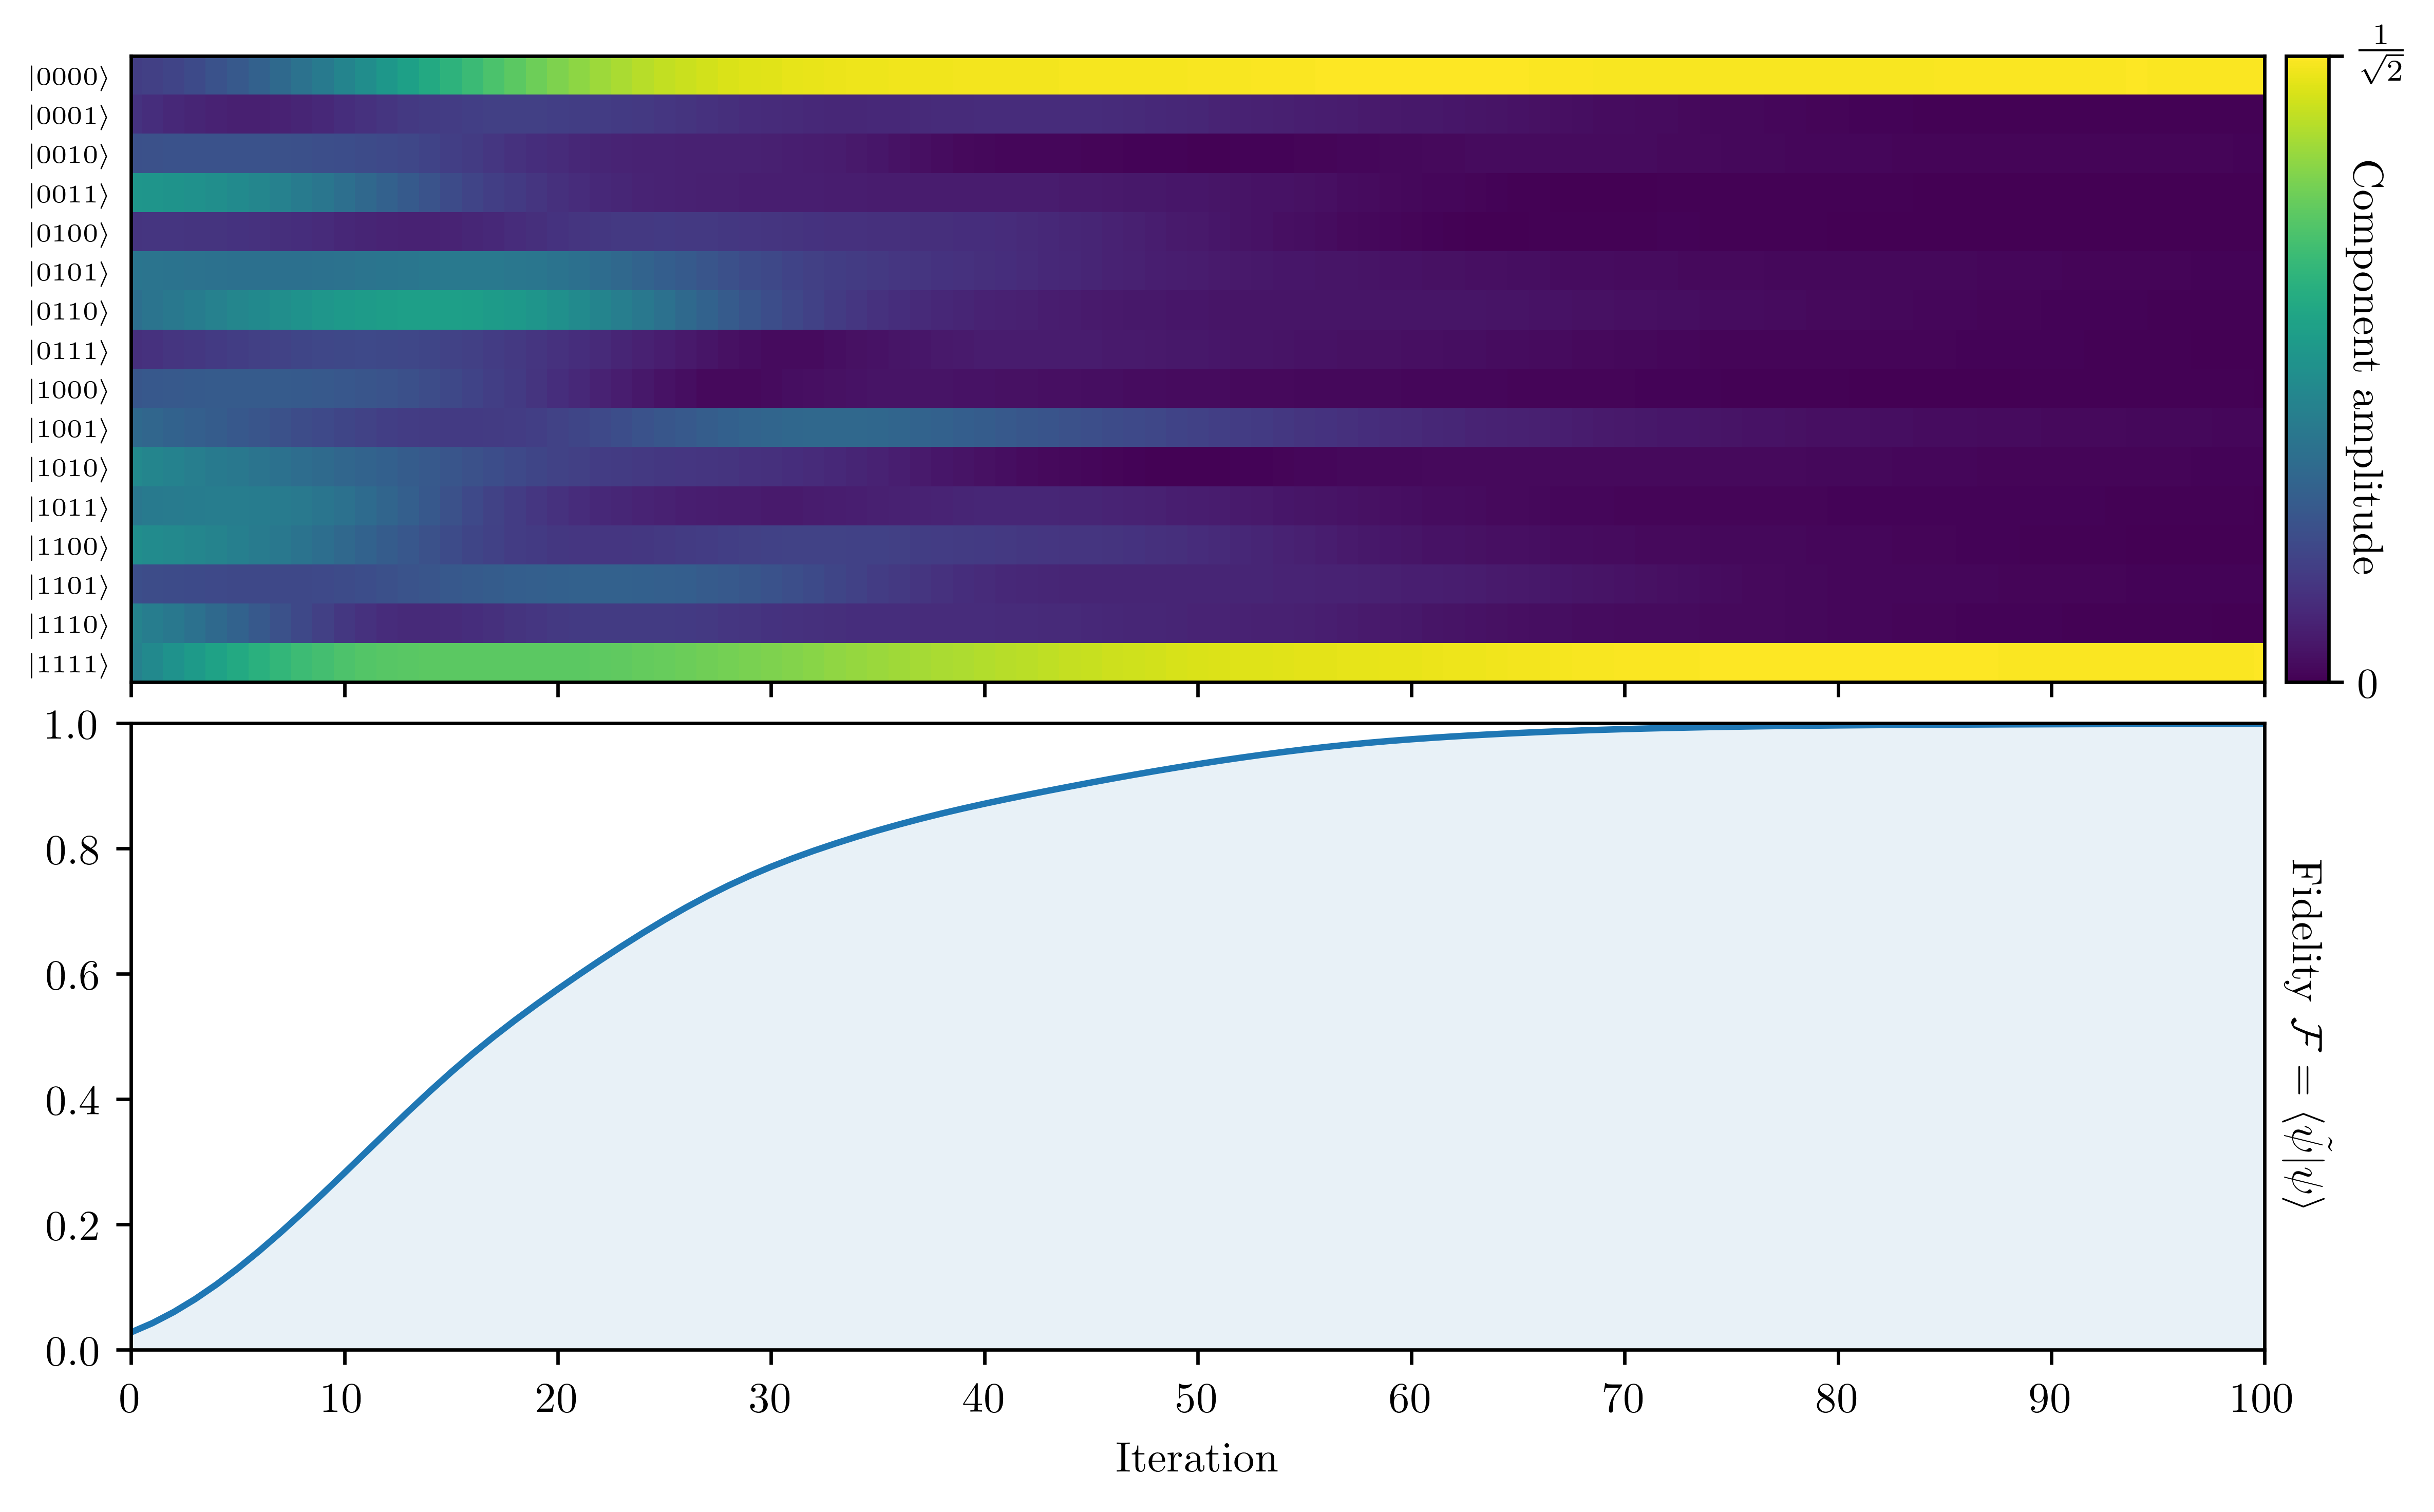

In [25]:
# output_states = np.transpose(k_to_np_complex(np.array(callback.output_states)[:,0]))
# plt.imshow(np.abs(output_states))
# plt.show()

plot_state_prep_training("./state_history_4_qubits_2019.08.19.17.51.17.h5", max_epoch=101)

## QFT plot

In [2]:
N = 4
in_data, out_data = prepare_training_data(QFT, N, 5000)

100%|██████████| 5000/5000 [00:06<00:00, 751.26it/s]


In [3]:
model = QPGA(N, 20).as_sequential()
model.build(in_data.shape)
model.compile(optimizer = Adam(lr = 0.01),
              loss = antifidelity,
              metrics = [antifidelity])

operator_vis = OperatorHistoryCallback(num_qubits=N, in_data=in_data, out_data=out_data)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.5,
                                              cooldown = 4,
                                              patience = 2,
                                              verbose = 1,
                                              min_lr = 1e-6)
callbacks = [operator_vis, reduce_lr]

history = model.fit(in_data, out_data,
                    epochs = 101,
                    validation_split = 0.1,
                    callbacks = callbacks,
                    verbose=1)

Train on 4500 samples, validate on 500 samples


W0826 15:58:06.970949 4389275072 deprecation.py:323] From /Users/ben/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


5000/5000 [==============================] - 4s 835us/sample - loss: 0.9404 - antifidelity: 0.9404
Initial fidelity: [0.9404369045138359, 0.9404369047378441]
Epoch 1/101
4500/4500 [==============================] - 16s 4ms/sample - loss: 0.5000 - antifidelity: 0.5000 - val_loss: 0.1726 - val_antifidelity: 0.1726
Epoch 2/101
4500/4500 [==============================] - 5s 1ms/sample - loss: 0.0889 - antifidelity: 0.0889 - val_loss: 0.0315 - val_antifidelity: 0.0315
Epoch 3/101
4500/4500 [==============================] - 5s 1ms/sample - loss: 0.0089 - antifidelity: 0.0089 - val_loss: 0.0015 - val_antifidelity: 0.0015
Epoch 4/101
4500/4500 [==============================] - 5s 1ms/sample - loss: 9.5182e-04 - antifidelity: 9.5182e-04 - val_loss: 7.2539e-04 - val_antifidelity: 7.2539e-04
Epoch 5/101
4500/4500 [==============================] - 5s 1ms/sample - loss: 5.7884e-04 - antifidelity: 5.7884e-04 - val_loss: 5.0746e-04 - val_antifidelity: 5.0746e-04
Epoch 6/101
4500/4500 [===========

In [13]:
# operator = extract_operator_from_model(model, N)
operator_targ = extract_operator_from_circuit(QFT, N)

# global_phase = np.mean(np.angle(operator/operator_targ))
# operator /= np.exp(1j * global_phase)

In [30]:
def loss_plot2(loss_val, loss_train=None, x_units="epochs", x_max=None, fig=None, ax=None, ylabel=None, ylabel_pos='left', log_fidelity=False):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4,4))
        
    if log_fidelity:
        loss_val = np.log10(loss_val)
        if loss_train is not None:
            loss_train = np.log10(loss_train)
    
    ax.plot(loss_val, linestyle='-', label="Validation")
    ax.fill_between(np.arange(len(loss_val)), loss_val, alpha=0.1)
    
    if loss_train is not None:
        ax.plot(loss_train, linestyle=':', label="Training")
        ax.legend(loc='upper left')
    
    if x_max is not None:
        ax.set_xlim(0, x_max-1)
    else:
        ax.set_xlim(0, len(loss_val)-1)
        
    if not log_fidelity:
        ax.set_ylim(0, 1)
    
    ax.yaxis.set_label_position(ylabel_pos)

    if ylabel is None:
        ylabel="Fidelity $\mathcal{F} = \left< \psi \\right| \\tilde{U}^{\\dagger} \hat{U} \left| \psi \\right>$"
    if ylabel_pos == 'left':
        ax.set_ylabel(ylabel, rotation=90)
    else:
        ax.set_ylabel(ylabel, rotation=270, va='bottom')
        
    
    if x_units == 'epochs':
        ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
        ax.set_xlabel("Epoch")
    elif x_units == 'iterations':
        ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
        ax.set_xlabel("Iteration")
    elif x_units == 'none':
        ax.set_xticks([])
        
    return fig, ax

In [13]:
def plot_frames(filepath, num_qubits=N):
    
    f = h5py.File(filepath, 'r')
    
    fidelities_train = np.array(f['fidelities_train'])
    fidelities_val = np.array(f['fidelities_val'])
    operators = np.array(f['operators'])
    
    num_epochs = len(fidelities_train)

    operator_targ = extract_operator_from_circuit(QFT, num_qubits)
    kets, bras = computational_basis_labels(num_qubits, include_bras=True)
    
    for i in pbar(range(num_epochs)):
        
        global_phase = np.mean(np.angle(operators[i]/operator_targ))
        operator = operators[i] / np.exp(1j * global_phase)

        # Make figure and axis layout
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        fig = plt.figure(figsize=(12,9), tight_layout=True)
        gs = mpl.gridspec.GridSpec(2, 2, height_ratios = [2, 1])

        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])

        # Plot operator visualizations
        hinton(operator, xlabels=kets, ylabels=bras, fig=fig, ax=ax1, title="$\\tilde{U}$")
        hinton(operator_targ, xlabels=kets, ylabels=bras, fig=fig, ax=ax2, title="$\hat{U}$")

        # Plot antifidelity
        fidel_val = fidelities_val[0:i]
        fidel_train = fidelities_train[0:i]
        ax_bot = fig.add_subplot(gs[1, :])
        loss_plot(fidel_val, fidel_train, x_units='iterations', x_max = num_epochs, fig=fig, ax=ax_bot)

        # Save frame
        title = str(i).zfill(4)
        plt.savefig("assets/frames/qft_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

In [120]:
plot_frames('scripts/logs/QFT_trainingoperator_history_5_qubits_2019.08.19.14.38.41.h5', num_qubits=5)

/Users/ben/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [8]:
filepath='./operator_history_4_qubits_2019.08.26.15.58.06.h5'
f = h5py.File(filepath, 'r')
    
fidelities_train = np.array(f['fidelities_train'])
fidelities_val = np.array(f['fidelities_val'])
operators = np.array(f['operators'])

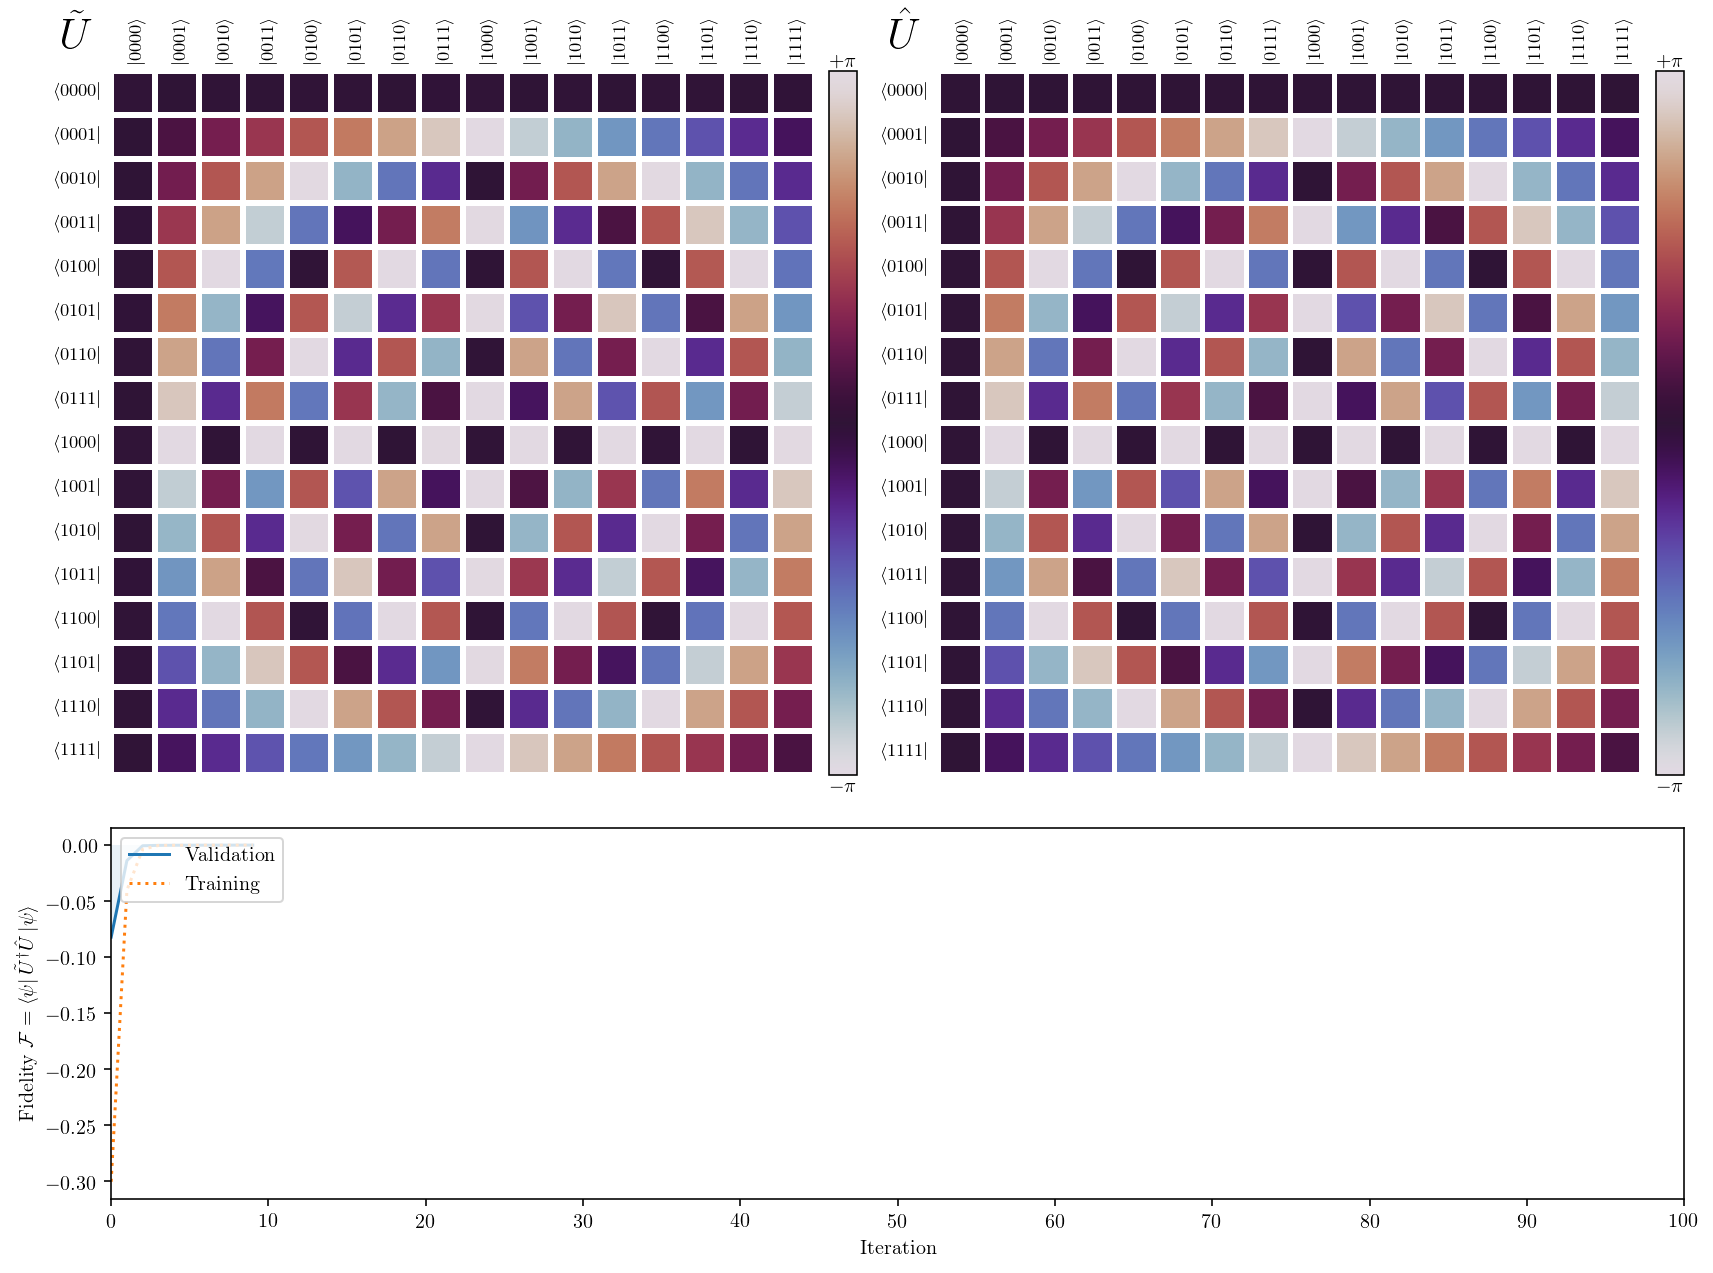

In [31]:
operator_callback = operator_vis
i=10

operator_targ = extract_operator_from_circuit(QFT, N)
kets, bras = computational_basis_labels(N, include_bras=True)
    
num_epochs = len(operator_callback.fidelities_train)

global_phase = np.mean(np.angle(operator_callback.operators[i]/operator_targ))
operator = operator_callback.operators[i] / np.exp(1j * global_phase)

# Make figure and axis layout
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=(12,9), tight_layout=True)
gs = mpl.gridspec.GridSpec(2, 2, height_ratios = [2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Plot operator visualizations
hinton(operator, xlabels=kets, ylabels=bras, fig=fig, ax=ax1, title="$\\tilde{U}$")
hinton(operator_targ, xlabels=kets, ylabels=bras, fig=fig, ax=ax2, title="$\hat{U}$")

# Plot antifidelity
fidel_val = operator_callback.fidelities_val[0:i]
fidel_train = operator_callback.fidelities_train[0:i]
ax_bot = fig.add_subplot(gs[1, :])
loss_plot2(fidel_val, fidel_train, x_units='iterations', x_max = num_epochs, fig=fig, ax=ax_bot, log_fidelity=True)

plt.show()

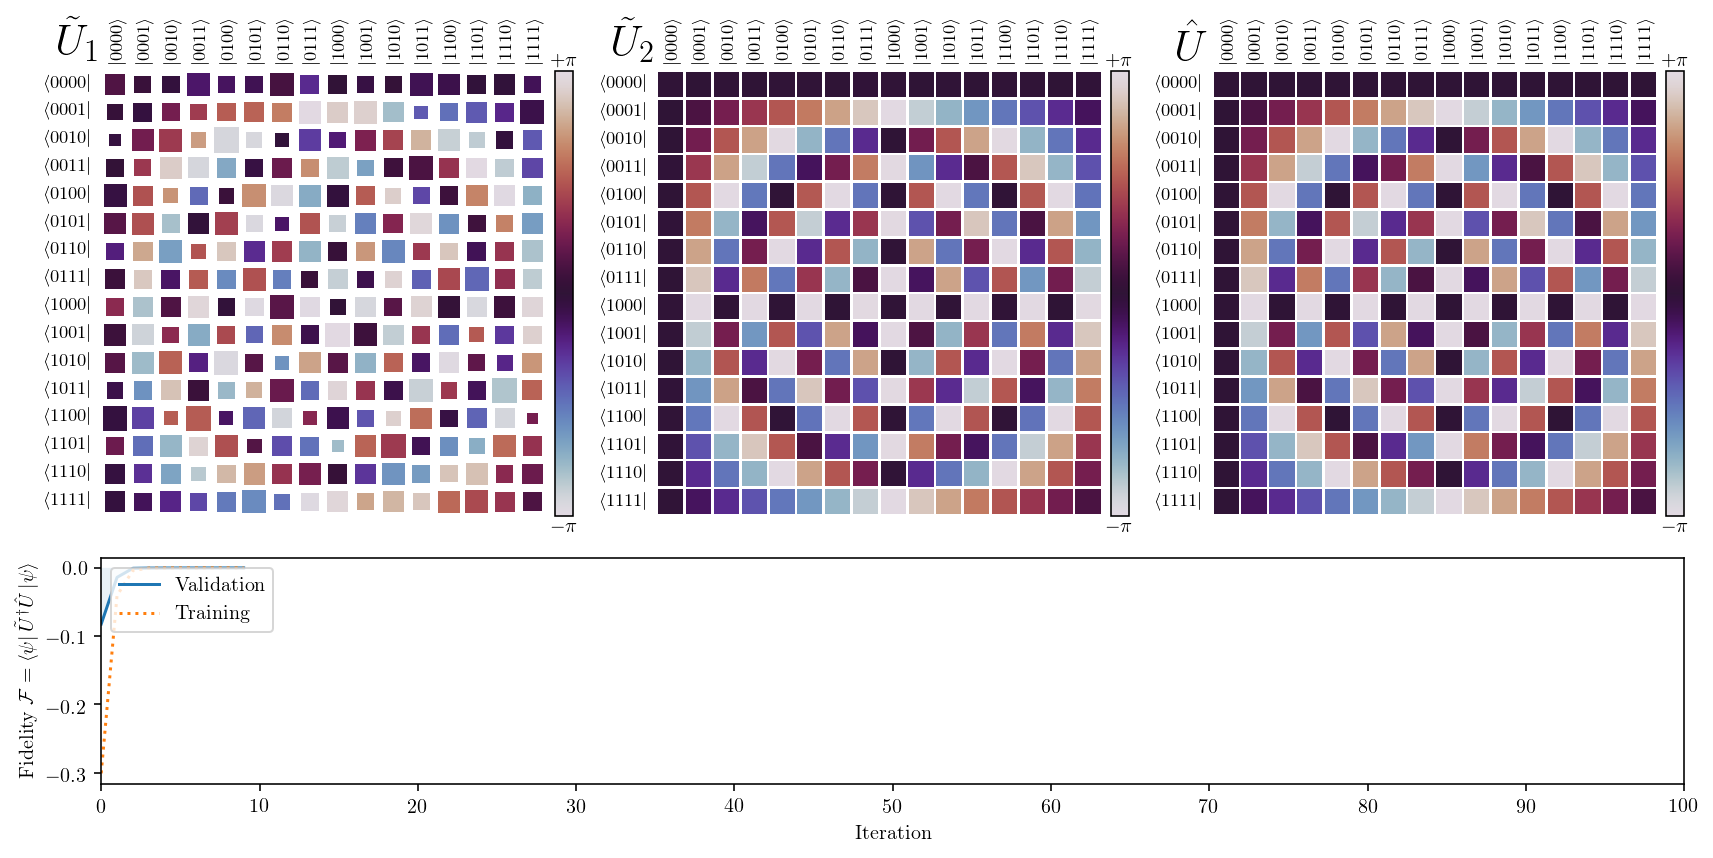

In [34]:
operator_callback = operator_vis
t1=0
t2=10

operator_targ = extract_operator_from_circuit(QFT, N)
kets, bras = computational_basis_labels(N, include_bras=True)
    
num_epochs = len(operator_callback.fidelities_train)

global_phase1 = np.mean(np.angle(operator_callback.operators[t1]/operator_targ))
operator1 = operator_callback.operators[t1] / np.exp(1j * global_phase1)

global_phase2 = np.mean(np.angle(operator_callback.operators[t2]/operator_targ))
operator2 = operator_callback.operators[t2] / np.exp(1j * global_phase2)

# Make figure and axis layout
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=(12, 12*(1/3 + 1/6)), tight_layout=True)
gs = mpl.gridspec.GridSpec(2, 3, height_ratios = [2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Plot operator visualizations
hinton(operator1, xlabels=kets, ylabels=bras, fig=fig, ax=ax1, title="$\\tilde{U}_1$")
hinton(operator2, xlabels=kets, ylabels=bras, fig=fig, ax=ax2, title="$\\tilde{U}_2$")
hinton(operator_targ, xlabels=kets, ylabels=bras, fig=fig, ax=ax3, title="$\hat{U}$")

# Plot antifidelity
fidel_val = operator_callback.fidelities_val[0:i]
fidel_train = operator_callback.fidelities_train[0:i]
ax_bot = fig.add_subplot(gs[1, :])
loss_plot2(fidel_val, fidel_train, x_units='iterations', x_max = num_epochs, fig=fig, ax=ax_bot, log_fidelity=True)

plt.show()

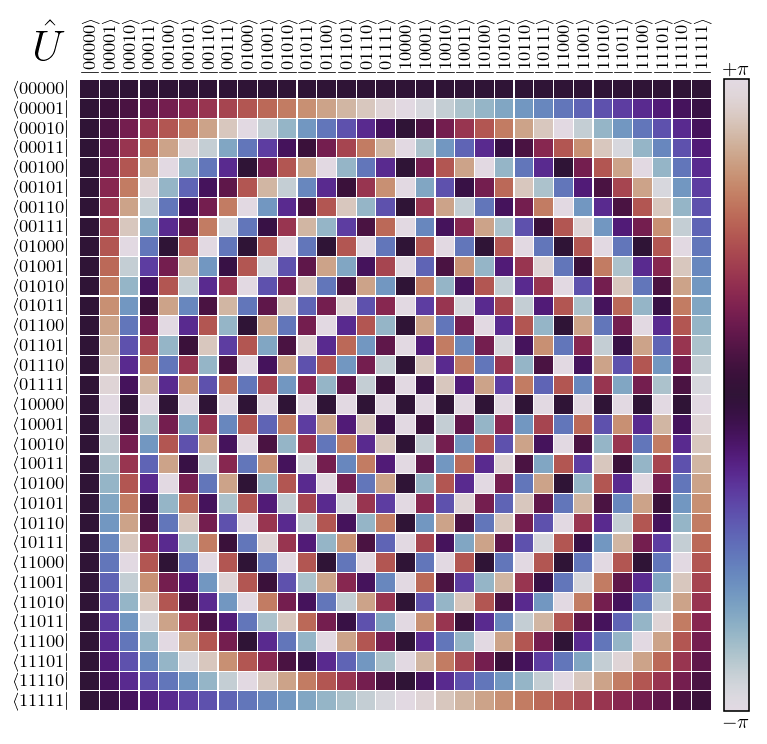

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

kets, bras = computational_basis_labels(5, include_bras=True)

# operator_targ = extract_operator_from_circuit(QFT, 5)

hinton(extract_operator_from_circuit(QFT, 5), xlabels=kets, ylabels=bras, title="$\hat{U}$", fig=fig, ax=ax)
# hinton(operator, xlabels=kets, ylabels=bras, fig=fig, ax=ax2)
plt.show()
# plt.savefig("assets/qft.png", dpi=300, bbox_inches='tight', pad_inches=0)

In [5]:
in_data, out_data = prepare_training_data(cluster_state_generator, 9, 10)

100%|██████████| 10/10 [00:00<00:00, 64.16it/s]

CZ(0, 1)
CZ(0, 3)
CZ(1, 2)
CZ(1, 4)
CZ(2, 5)
CZ(3, 4)
CZ(3, 6)
CZ(4, 5)
CZ(4, 7)
CZ(5, 8)
CZ(6, 7)
CZ(7, 8)
CZ(0, 1)
CZ(0, 3)
CZ(1, 2)
CZ(1, 4)
CZ(2, 5)
CZ(3, 4)
CZ(3, 6)
CZ(4, 5)
CZ(4, 7)
CZ(5, 8)
CZ(6, 7)
CZ(7, 8)
CZ(0, 1)
CZ(0, 3)
CZ(1, 2)
CZ(1, 4)
CZ(2, 5)
CZ(3, 4)
CZ(3, 6)
CZ(4, 5)
CZ(4, 7)
CZ(5, 8)
CZ(6, 7)
CZ(7, 8)
CZ(0, 1)
CZ(0, 3)
CZ(1, 2)
CZ(1, 4)
CZ(2, 5)
CZ(3, 4)
CZ(3, 6)
CZ(4, 5)
CZ(4, 7)
CZ(5, 8)
CZ(6, 7)
CZ(7, 8)
CZ(0, 1)
CZ(0, 3)
CZ(1, 2)
CZ(1, 4)
CZ(2, 5)
CZ(3, 4)
CZ(3, 6)
CZ(4, 5)
CZ(4, 7)
CZ(5, 8)
CZ(6, 7)
CZ(7, 8)
CZ(0, 1)
CZ(0, 3)
CZ(1, 2)
CZ(1, 4)
CZ(2, 5)
CZ(3, 4)
CZ(3, 6)
CZ(4, 5)
CZ(4, 7)
CZ(5, 8)
CZ(6, 7)
CZ(7, 8)
CZ(0, 1)
CZ(0, 3)
CZ(1, 2)
CZ(1, 4)
CZ(2, 5)
CZ(3, 4)
CZ(3, 6)
CZ(4, 5)
CZ(4, 7)
CZ(5, 8)
CZ(6, 7)
CZ(7, 8)
CZ(0, 1)
CZ(0, 3)
CZ(1, 2)
CZ(1, 4)
CZ(2, 5)
CZ(3, 4)
CZ(3, 6)
CZ(4, 5)
CZ(4, 7)
CZ(5, 8)
CZ(6, 7)
CZ(7, 8)
CZ(0, 1)
CZ(0, 3)
CZ(1, 2)
CZ(1, 4)
CZ(2, 5)
CZ(3, 4)
CZ(3, 6)
CZ(4, 5)
CZ(4, 7)
CZ(5, 8)
CZ(6, 7)
CZ(7, 8)
CZ(0, 1)
CZ(0, 3)
CZ(1, 2)
C

In [8]:
N=9
model = QPGA(N, 100).as_sequential()
model.compile(optimizer=Adam(lr=0.01), 
              loss=antifidelity, 
              metrics=[antifidelity])

callback = StatePreparationHistoryCallback(num_qubits=N, input_state = in_data[0:1], target_state = out_data[0:1], filename="9_qubit_cluster_state.h5")
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor = 'loss', 
                                                       factor = 0.25,
                                                       patience = 2,
                                                       verbose=1,
                                                       min_lr=1e-6)

history = model.fit(in_data, out_data, epochs=101, 
                    callbacks=[callback, reduce_lr_callback], verbose = 2)

Epoch 1/101
10/10 - 234s - loss: 0.9987 - antifidelity: 0.9987
Epoch 2/101
10/10 - 9s - loss: 0.9841 - antifidelity: 0.9841
Epoch 3/101
10/10 - 9s - loss: 0.9636 - antifidelity: 0.9636
Epoch 4/101
10/10 - 9s - loss: 0.9445 - antifidelity: 0.9445
Epoch 5/101
10/10 - 9s - loss: 0.9290 - antifidelity: 0.9290
Epoch 6/101
10/10 - 10s - loss: 0.9156 - antifidelity: 0.9156
Epoch 7/101
10/10 - 9s - loss: 0.9020 - antifidelity: 0.9020
Epoch 8/101
10/10 - 9s - loss: 0.8880 - antifidelity: 0.8880
Epoch 9/101
10/10 - 9s - loss: 0.8764 - antifidelity: 0.8764
Epoch 10/101
10/10 - 9s - loss: 0.8663 - antifidelity: 0.8663
Epoch 11/101
10/10 - 9s - loss: 0.8558 - antifidelity: 0.8558
Epoch 12/101
10/10 - 9s - loss: 0.8457 - antifidelity: 0.8457
Epoch 13/101
10/10 - 9s - loss: 0.8364 - antifidelity: 0.8364
Epoch 14/101
10/10 - 9s - loss: 0.8277 - antifidelity: 0.8277
Epoch 15/101
10/10 - 9s - loss: 0.8197 - antifidelity: 0.8197
Epoch 16/101
10/10 - 9s - loss: 0.8119 - antifidelity: 0.8119
Epoch 17/101
1

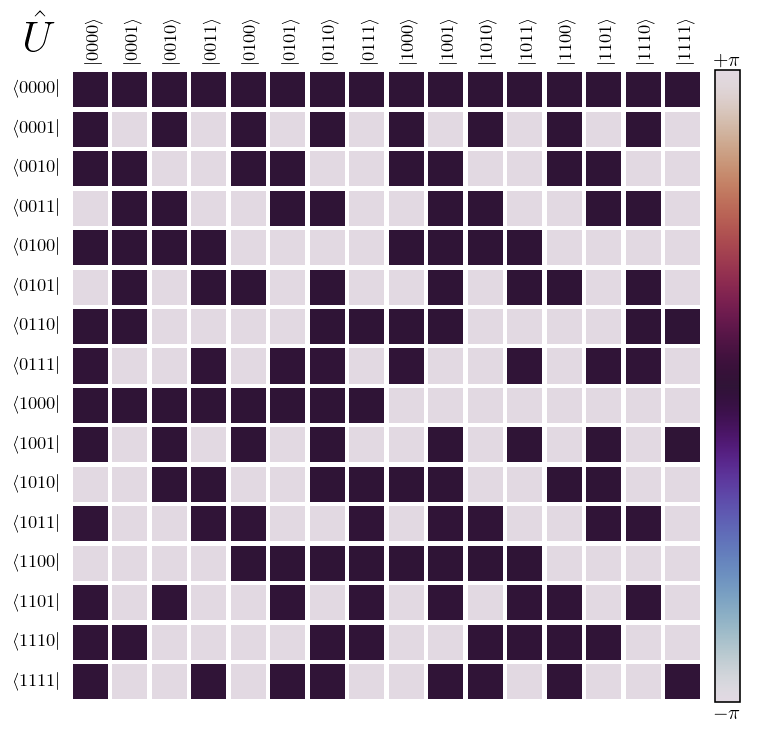

In [3]:
N=4

fig, ax = plt.subplots(1, 1, figsize=(6,6))

kets, bras = computational_basis_labels(N, include_bras=True)

# operator_targ = extract_operator_from_circuit(QFT, 5)

hinton(extract_operator_from_circuit(cluster_state_generator, N), xlabels=kets, ylabels=bras, title="$\hat{U}$", fig=fig, ax=ax)
# hinton(operator, xlabels=kets, ylabels=bras, fig=fig, ax=ax2)
plt.show()

In [5]:
in_data, out_data = prepare_training_data(cluster_state_generator, N, 1)
print(k_to_np_complex(out_data))

100%|██████████| 1/1 [00:00<00:00, 376.37it/s]

[[ 0.25+0.000e+00j  0.25+0.000e+00j  0.25+0.000e+00j -0.25+3.062e-17j  0.25+0.000e+00j -0.25+3.062e-17j  0.25+0.000e+00j  0.25-6.123e-17j  0.25+0.000e+00j  0.25+0.000e+00j -0.25+3.062e-17j  0.25-6.123e-17j -0.25+3.062e-17j  0.25-6.123e-17j  0.25-6.123e-17j  0.25-1.225e-16j]]


In [6]:
print(np.angle(k_to_np_complex(out_data)))

[[ 0.000e+00  0.000e+00  0.000e+00  3.142e+00  0.000e+00  3.142e+00  0.000e+00 -2.449e-16  0.000e+00  0.000e+00  3.142e+00 -2.449e-16  3.142e+00 -2.449e-16 -2.449e-16 -4.899e-16]]
